# Computing Entropy

In this notebook we will walkthrough entropy computations and some of the options associated with them.

### Imports

For all entropy calculations we will use the neural tangent kernel. Therefore, we will exclusively be using the neural tangents library.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import znrnd
from neural_tangents import stax
import optax

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import jax
jax.default_backend()

2022-08-23 14:02:52.687406: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


'cpu'

### Data generators

For the sake of covereage, we will look at the entropy of the all the data generators on small networks

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()
dataset = dataset.dropna()
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')


dataset = (dataset-dataset.mean())/dataset.std()

class MPGDataGenerator(znrnd.data.DataGenerator):
    """
    Data generator for the MPG dataset.
    """
    def __init__(self, dataset: pd.DataFrame):
        """
        Constructor for the data generator.
        
        Parameters
        ----------
        dataset
        """        
        train_ds = dataset.sample(frac=0.8, random_state=0)
        train_labels = train_ds.pop("MPG")
        test_ds = dataset.drop(train_ds.index)
        test_labels = test_ds.pop("MPG")
        
        self.train_ds = {"inputs": train_ds.to_numpy(), "targets": train_labels.to_numpy().reshape(-1, 1)}
        self.test_ds = {"inputs": test_ds.to_numpy(), "targets": test_labels.to_numpy().reshape(-1, 1)}
        
        self.data_pool = self.train_ds["inputs"]


In [3]:
mnist_generator = znrnd.data.MNISTGenerator()
cifar_generator = znrnd.data.CIFAR10Generator()
fuel_generator = MPGDataGenerator(dataset)

2022-08-23 14:03:12.706482: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


###  Networks and Models

Now we can define the network architectures for which we will compute the entropy of the data. Let's use a dense network for the fuel data and a convolutional network for the others.

In [4]:
dense_network = stax.serial(
    stax.Dense(32),
    stax.Relu(),
    stax.Dense(32),
)

convolutional_network = stax.serial(
    stax.Conv(64, filter_shape=(2, 2)),
    stax.Relu(),
    stax.AvgPool(window_shape=(2, 2), strides=(2, 2)),
    stax.Flatten(),
    stax.Dense(128),
)

In [5]:
fuel_model = znrnd.models.NTModel(
    nt_module=dense_network,
    optimizer=optax.adam(learning_rate=0.001),
    loss_fn=znrnd.loss_functions.MeanPowerLoss(order=2),
    input_shape=(9,),
    training_threshold=0.001,
    batch_size=5
)
mnist_model = znrnd.models.NTModel(
    nt_module=convolutional_network,
    optimizer=optax.adam(learning_rate=0.001),
    loss_fn=znrnd.loss_functions.CrossEntropyLoss(classes=10, apply_softmax=False),
    input_shape=(1, 28, 28, 1),
    training_threshold=0.001,
    batch_size=1
)
cifar_model = znrnd.models.NTModel(
    nt_module=convolutional_network,
    optimizer=optax.adam(learning_rate=0.001),
    loss_fn=znrnd.loss_functions.CrossEntropyLoss(classes=10, apply_softmax=False),
    input_shape=(1, 32, 32, 3),
    training_threshold=0.001,
    batch_size=1
)

### Computing the Entropy

Let's compute the entropy of a small subset of the data points, let's say, 10 points from each. To do so, we will perform the following steps:

1. Select the subset of data.
2. Compute the NTK matrix for each model.
3. Instantiate an entropy calculator for each matrix.
4. Compute the entropy for each matrix.

In [6]:
# Step 1

fuel_data = fuel_generator[0:10]
mnist_data = mnist_generator[0:10]
cifar_data = cifar_generator[0:10]

In [7]:
# Step 2

fuel_ntk = fuel_model.compute_ntk(fuel_data, normalize=False)["empirical"]
mnist_ntk = mnist_model.compute_ntk(mnist_data, normalize=False)["empirical"]
cifar_ntk = cifar_model.compute_ntk(cifar_data, normalize=False)["empirical"]

/tikhome/stovey/miniconda3/envs/zincware/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


In [8]:
# Step 3

fuel_calculator = znrnd.analysis.EntropyAnalysis(matrix=fuel_ntk)
mnist_calculator = znrnd.analysis.EntropyAnalysis(matrix=mnist_ntk)
cifar_calculator = znrnd.analysis.EntropyAnalysis(matrix=cifar_ntk)

In [9]:
# Step 4

fuel_entropy = fuel_calculator.compute_von_neumann_entropy(
    effective=True, normalize_eig=True
)
mnist_entropy = mnist_calculator.compute_von_neumann_entropy(
    effective=True, normalize_eig=True
)
cifar_entropy = cifar_calculator.compute_von_neumann_entropy(
    effective=True, normalize_eig=True
)

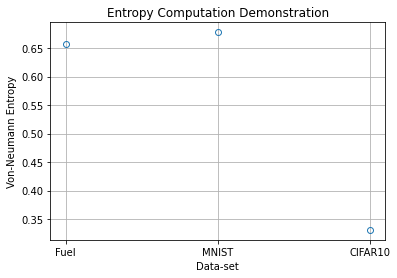

In [10]:
plt.plot(["Fuel", "MNIST", "CIFAR10"], [fuel_entropy, mnist_entropy, cifar_entropy], 'o', mfc="none")
plt.grid()
plt.xlabel("Data-set")
plt.ylabel("Von-Neumann Entropy")
plt.title("Entropy Computation Demonstration")
plt.show()